In [1]:
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
import re
import torch
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ormeiri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('/Users/ormeiri/Desktop/Work/sci-search/parser/data/combined_data_new.csv')
df

,term_id,langs,country,term,type,code_lang,hl,gl,Collection date,Result number,...,Is there reference to everyday life?,Is there reference to everyday life? פרופורציה,Are there local examples in the content? (e.g. relevant case study in a country or ethnic group that speaks the language of the content),Are there local examples in the content? (e.g. relevant case study in a country or ethnic group that speaks the language of the content)פרופורציה,Does the content present advantages and disadvantages or risks and benefits?,Does the content present advantages and disadvantages or risks and benefits? פרופורציה,ssi_mean,SSI mean פרופורציה Integrated,raw_html,extracted_text
0,70,Zulu,"Cape Town,Western Cape,South Africa",Isikhukhula,Socio-Scientific Issues,zu,zu,za,20.2.2023,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<html>\r\n<head>\r\n<META NAME=""robots"" CONTEN...",NaN
1,71,Zulu,"Cape Town,Western Cape,South Africa",Isomiso,Socio-Scientific Issues,zu,zu,za,20.2.2023,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,\n \n\n\n\n\n\n\n\n\n<!DOCTYPE html>\n<html x...,\ndrought\n
2,71,Zulu,"Cape Town,Western Cape,South Africa",Isomiso,Socio-Scientific Issues,zu,zu,za,20.2.2023,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<!doctype html><html lang=""en""><head><script>v...",NaN
3,29,Zulu,"Cape Town,Western Cape,South Africa",Isisindo,Canonical Scientific Issues,zu,zu,za,20.2.2023,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<!DOCTYPE html><html style=""font-size: 10px;fo...",NaN
4,29,Zulu,"Cape Town,Western Cape,South Africa",Isisindo,Canonical Scientific Issues,zu,zu,za,20.2.2023,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<!DOCTYPE html><html style=""font-size: 10px;fo...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4156,56,Ukrainian,"Kyiv,Kyiv city,Ukraine",калорія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,4.0,...,2.0,1.0,1.0,0.5,2.0,1.0,0.833333,0.833333,"<!DOCTYPE html>\n<html lang=""uk"">\n<head> \n\...",Фітнес портал Калорійність продуктів — як її п...
4157,58,Ukrainian,"Kyiv,Kyiv city,Ukraine",відновлювальна енергія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,2.0,...,2.0,1.0,1.0,0.5,2.0,1.0,0.833333,0.833333,"<!DOCTYPE html><html lang=""uk""><head><meta cha...","Відновлювану енергію можна отримувати з води, ..."
4158,58,Ukrainian,"Kyiv,Kyiv city,Ukraine",відновлювальна енергія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,3.0,...,2.0,1.0,2.0,1.0,2.0,1.0,1.000000,1.000000,"<!DOCTYPE html><html style=""font-size: 10px;fo...",NaN
4159,12,Ukrainian,"Kyiv,Kyiv city,Ukraine",гриб,Canonical Scientific Issues,uk,uk,ua,22.12.2022,8.0,...,2.0,1.0,2.0,1.0,2.0,1.0,1.000000,NaN,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",У лісі поблизу Ворохти виявили гігантський біл...


In [3]:
def clean_text(text):
    text = str(text)
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

In [4]:
df['cleaned_text'] = df['extracted_text'].apply(clean_text)
X = df[df['cleaned_text'] != 'nan']
X

,term_id,langs,country,term,type,code_lang,hl,gl,Collection date,Result number,...,Is there reference to everyday life? פרופורציה,Are there local examples in the content? (e.g. relevant case study in a country or ethnic group that speaks the language of the content),Are there local examples in the content? (e.g. relevant case study in a country or ethnic group that speaks the language of the content)פרופורציה,Does the content present advantages and disadvantages or risks and benefits?,Does the content present advantages and disadvantages or risks and benefits? פרופורציה,ssi_mean,SSI mean פרופורציה Integrated,raw_html,extracted_text,cleaned_text
1,71,Zulu,"Cape Town,Western Cape,South Africa",Isomiso,Socio-Scientific Issues,zu,zu,za,20.2.2023,1.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,\n \n\n\n\n\n\n\n\n\n<!DOCTYPE html>\n<html x...,\ndrought\n,\ndrought\n
5,35,Zulu,"Cape Town,Western Cape,South Africa",amaplanethi azungeza ilanga,Canonical Scientific Issues,zu,zu,za,20.2.2023,1.0,...,0.5,1.0,0.5,1.0,0.5,0.500000,0.500000,"<!DOCTYPE html><html lang=""zu"" dir=""ltr""><head...",Isikhala kusuka ku-A kuya ku-Z Ngaphandle kwe-...,Isikhala kusuka kuA kuya kuZ Ngaphandle kweMer...
6,43,Zulu,"Cape Town,Western Cape,South Africa",Ulibofuzo,Novel Science and Technology Issues,zu,zu,za,20.2.2023,2.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<!doctype html>\n <html lang=""zu"">\n <he...","Nkosikhona Cele | June 11, 2022 SITHOLAKALE ...",Nkosikhona Cele June 11 2022 SITHOLAKALE si...
8,54,Zulu,"Cape Town,Western Cape,South Africa",Ukuba nokudla,Socio-Scientific Issues,zu,zu,za,20.2.2023,3.0,...,1.0,0.0,0.0,0.0,0.0,0.333333,NaN,"\r\n\r\n<!DOCTYPE html PUBLIC ""-//W3C//DTD XHT...","I-College of Agriculture, Engineering and Scie...",ICollege of Agriculture Engineering and Scienc...
9,56,Zulu,"Cape Town,Western Cape,South Africa",Ikhalori,Socio-Scientific Issues,zu,zu,za,20.2.2023,3.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<!DOCTYPE html>\n<html ⚡ lang=""en-US"">\n<head>...","Omunye izitsha athandwa kakhulu, okuyinto, ka...",Omunye izitsha athandwa kakhulu okuyinto kany...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,56,Ukrainian,"Kyiv,Kyiv city,Ukraine",калорія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,3.0,...,1.0,2.0,1.0,2.0,1.0,1.000000,1.000000,"<!doctype html><html lang=""uk""><head><meta...","\nПрирода влаштувала нас так, що, навіть з`ївш...",\nПрирода влаштувала нас так що навіть зївши з...
4156,56,Ukrainian,"Kyiv,Kyiv city,Ukraine",калорія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,4.0,...,1.0,1.0,0.5,2.0,1.0,0.833333,0.833333,"<!DOCTYPE html>\n<html lang=""uk"">\n<head> \n\...",Фітнес портал Калорійність продуктів — як її п...,Фітнес портал Калорійність продуктів як її пр...
4157,58,Ukrainian,"Kyiv,Kyiv city,Ukraine",відновлювальна енергія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,2.0,...,1.0,1.0,0.5,2.0,1.0,0.833333,0.833333,"<!DOCTYPE html><html lang=""uk""><head><meta cha...","Відновлювану енергію можна отримувати з води, ...",Відновлювану енергію можна отримувати з води в...
4159,12,Ukrainian,"Kyiv,Kyiv city,Ukraine",гриб,Canonical Scientific Issues,uk,uk,ua,22.12.2022,8.0,...,1.0,2.0,1.0,2.0,1.0,1.000000,NaN,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",У лісі поблизу Ворохти виявили гігантський біл...,У лісі поблизу Ворохти виявили гігантський біл...


In [5]:
def normalize_text(text):
    # Regex to match dates in various formats
    date_patterns = [
        r'\b\d{1,2}[\/.-]\d{1,2}[\/.-]\d{2,4}\b',  # Numeric dates like 19/09/2024, 25.12.2012
        r'\b\d{4}[\/.-]\d{1,2}[\/.-]\d{1,2}\b',  # Numeric dates like 2024-09-19
        r'\b\d{1,2}\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{4}\b',  # Dates like 15 Nov 2013, 1 January 2022
        r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},?\s+\d{4}\b',  # Dates like March 15, 2023 and March 15 2023
        r'\b\d{1,2}\s+(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4}\b',  # Dates like 15 March 2023
    ]
    # Combine all date regex patterns into one
    date_regex = '|'.join(date_patterns)

    text = re.sub(date_regex, '<date>', text)  # Replace dates with <date>
    # URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '<url>', text)
    # Email addresses
    text = re.sub(r'\b[\w.-]+?@\w+?\.\w{2,4}\b', '<email>', text)
    # Money amounts
    text = re.sub(r'\$\d+(?:\.\d{2})?', '<money>', text)
    # Phone numbers
    text = re.sub(r'\b\d{3}-\d{4}\b', '<phone>', text)

    return text

In [6]:
X['cleaned_text'] = X['cleaned_text'].apply(normalize_text)
X

/var/folders/68/dmpmrx5n0ts80f_y59l1n8y00000gn/T/ipykernel_71251/3863618037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cleaned_text'] = X['cleaned_text'].apply(normalize_text)


,term_id,langs,country,term,type,code_lang,hl,gl,Collection date,Result number,...,Is there reference to everyday life? פרופורציה,Are there local examples in the content? (e.g. relevant case study in a country or ethnic group that speaks the language of the content),Are there local examples in the content? (e.g. relevant case study in a country or ethnic group that speaks the language of the content)פרופורציה,Does the content present advantages and disadvantages or risks and benefits?,Does the content present advantages and disadvantages or risks and benefits? פרופורציה,ssi_mean,SSI mean פרופורציה Integrated,raw_html,extracted_text,cleaned_text
1,71,Zulu,"Cape Town,Western Cape,South Africa",Isomiso,Socio-Scientific Issues,zu,zu,za,20.2.2023,1.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,\n \n\n\n\n\n\n\n\n\n<!DOCTYPE html>\n<html x...,\ndrought\n,\ndrought\n
5,35,Zulu,"Cape Town,Western Cape,South Africa",amaplanethi azungeza ilanga,Canonical Scientific Issues,zu,zu,za,20.2.2023,1.0,...,0.5,1.0,0.5,1.0,0.5,0.500000,0.500000,"<!DOCTYPE html><html lang=""zu"" dir=""ltr""><head...",Isikhala kusuka ku-A kuya ku-Z Ngaphandle kwe-...,Isikhala kusuka kuA kuya kuZ Ngaphandle kweMer...
6,43,Zulu,"Cape Town,Western Cape,South Africa",Ulibofuzo,Novel Science and Technology Issues,zu,zu,za,20.2.2023,2.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<!doctype html>\n <html lang=""zu"">\n <he...","Nkosikhona Cele | June 11, 2022 SITHOLAKALE ...",Nkosikhona Cele <date> SITHOLAKALE sinqunyw...
8,54,Zulu,"Cape Town,Western Cape,South Africa",Ukuba nokudla,Socio-Scientific Issues,zu,zu,za,20.2.2023,3.0,...,1.0,0.0,0.0,0.0,0.0,0.333333,NaN,"\r\n\r\n<!DOCTYPE html PUBLIC ""-//W3C//DTD XHT...","I-College of Agriculture, Engineering and Scie...",ICollege of Agriculture Engineering and Scienc...
9,56,Zulu,"Cape Town,Western Cape,South Africa",Ikhalori,Socio-Scientific Issues,zu,zu,za,20.2.2023,3.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<!DOCTYPE html>\n<html ⚡ lang=""en-US"">\n<head>...","Omunye izitsha athandwa kakhulu, okuyinto, ka...",Omunye izitsha athandwa kakhulu okuyinto kany...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,56,Ukrainian,"Kyiv,Kyiv city,Ukraine",калорія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,3.0,...,1.0,2.0,1.0,2.0,1.0,1.000000,1.000000,"<!doctype html><html lang=""uk""><head><meta...","\nПрирода влаштувала нас так, що, навіть з`ївш...",\nПрирода влаштувала нас так що навіть зївши з...
4156,56,Ukrainian,"Kyiv,Kyiv city,Ukraine",калорія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,4.0,...,1.0,1.0,0.5,2.0,1.0,0.833333,0.833333,"<!DOCTYPE html>\n<html lang=""uk"">\n<head> \n\...",Фітнес портал Калорійність продуктів — як її п...,Фітнес портал Калорійність продуктів як її пр...
4157,58,Ukrainian,"Kyiv,Kyiv city,Ukraine",відновлювальна енергія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,2.0,...,1.0,1.0,0.5,2.0,1.0,0.833333,0.833333,"<!DOCTYPE html><html lang=""uk""><head><meta cha...","Відновлювану енергію можна отримувати з води, ...",Відновлювану енергію можна отримувати з води в...
4159,12,Ukrainian,"Kyiv,Kyiv city,Ukraine",гриб,Canonical Scientific Issues,uk,uk,ua,22.12.2022,8.0,...,1.0,2.0,1.0,2.0,1.0,1.000000,NaN,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",У лісі поблизу Ворохти виявили гігантський біл...,У лісі поблизу Ворохти виявили гігантський біл...


In [7]:
stop_words_set = set()
# Get unique languages from the 'langs' column
unique_langs = X['langs'].unique()  # Add more languages as needed

# Convert to Pandas Series
series_with_nan = pd.Series(unique_langs)

# Removing NaN values
cleaned_series = series_with_nan.dropna()


# Convert back to ndarray if necessary
cleaned_array = cleaned_series.to_numpy()

for lang in cleaned_array:
    try:
        stop_words_set.update(stopwords.words(lang))
    except OSError:
        print(f"No stop words found for '{lang}' in NLTK.")

No stop words found for 'Zulu' in NLTK.
No stop words found for 'Hindi' in NLTK.
No stop words found for 'Taiwanese' in NLTK.
No stop words found for 'Japanese' in NLTK.
No stop words found for 'Afrikaans' in NLTK.
No stop words found for 'Korean' in NLTK.
No stop words found for 'Vietnamese' in NLTK.
No stop words found for 'Swahili' in NLTK.
No stop words found for 'Ukrainian' in NLTK.


In [8]:
def remove_stopwords(text, stopwords):
    words = text.lower().split()  # Convert text to lowercase before splitting
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

In [9]:
# Apply the function to the cleaned_text column
X['cleaned_text'] = X['cleaned_text'].apply(lambda x: remove_stopwords(x, stop_words_set))

/var/folders/68/dmpmrx5n0ts80f_y59l1n8y00000gn/T/ipykernel_71251/1613584100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cleaned_text'] = X['cleaned_text'].apply(lambda x: remove_stopwords(x, stop_words_set))


In [10]:
# Initialize a Counter object to store word counts
word_counts = Counter()

# Tokenize each entry and update the Counter
for text in X['cleaned_text']:
    # Split the text into words based on spaces and update counts
    word_counts.update(text.split())
    
word_counts

Counter({'это': 66686,
         'луне': 60727,
         'луны': 43661,
         'астронавты': 33338,
         'nasa': 31783,
         'луну': 31667,
         'года': 24196,
         'земле': 23632,
         'лунной': 23395,
         'время': 22644,
         'очень': 20760,
         'полета': 20418,
         'земли': 20212,
         'астронавтов': 19841,
         'несколько': 19758,
         'лунного': 18636,
         'фотографии': 18114,
         'поверхности': 17743,
         'поэтому': 16605,
         'лунный': 16168,
         'американцы': 15755,
         'действительно': 14921,
         'apollo': 14731,
         'г': 14703,
         'лишь': 14477,
         'क': 13399,
         'двигателя': 13378,
         'полетов': 12970,
         'просто': 12707,
         'лунных': 12648,
         'которые': 12458,
         'аполлонов': 12373,
         'человек': 12253,
         'поверхность': 12113,
         'астронавтами': 11950,
         'также': 11911,
         'раза': 11795,
         'изза':

In [11]:
# Remove rows where any of the target variables are NaN
combined_df = X.dropna(subset=['quality_mean', 'accessibility_mean'])
# Create a combined DataFrame (assuming 'quality_mean', 'accessibility_mean', 'ssi_mean' are columns in df)
combined_df = combined_df[['cleaned_text', 'quality_mean', 'accessibility_mean']]
combined_df

,cleaned_text,quality_mean,accessibility_mean
1,drought,0.266667,0.333333
5,isikhala kusuka kua kuya kuz ngaphandle kwemer...,0.733333,0.638889
6,nkosikhona cele <date> sitholakale sinqunywe i...,0.600000,0.416667
8,icollege agriculture engineering science icaes...,0.333333,0.500000
9,omunye izitsha athandwa kakhulu okuyinto kanye...,0.116667,0.416667
...,...,...,...
4155,природа влаштувала що навіть зївши зайве людин...,0.566667,0.833333
4156,фітнес портал калорійність продуктів як її пра...,0.716667,0.916667
4157,відновлювану енергію можна отримувати з води в...,0.516667,0.833333
4159,лісі поблизу ворохти виявили гігантський білий...,0.400000,0.500000


In [12]:
# Split data into features (X) and target (y)
X_data = combined_df['cleaned_text']
# Create separate datasets for each target
y_quality = combined_df['quality_mean']
y_accessibility = combined_df['accessibility_mean']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_quality, test_size=0.2, random_state=42)

In [14]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_data)  # Fit to the entire dataset to define the vocabulary

TfidfVectorizer()

In [15]:
def train_linear_model(X_train, y_train, X_test, vectorizer):
    X_train_tfidf = vectorizer.transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    # Clip predictions
    predictions = np.clip(predictions, 0, 1)
    return model, predictions

In [16]:
# def train_ridge_model(X_train, y_train, X_test, alpha=1.0):
#     pipeline = make_pipeline(TfidfVectorizer(), Ridge(alpha=alpha))
#     pipeline.fit(X_train, y_train)
#     predictions = pipeline.predict(X_test)
#     predictions = np.clip(predictions, 0, 1)
#     return pipeline, predictions
def train_ridge_model(X_train, y_train, X_test, vectorizer, alpha=1.0):
    # Use the pre-fitted vectorizer to transform data
    X_train_tfidf = vectorizer.transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train Ridge regression model
    model = Ridge(alpha=alpha)
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    predictions = np.clip(predictions, 0, 1)

    return model, predictions

In [17]:
def train_random_forest_model(X_train, y_train, X_test, vectorizer, n_estimators=100):
    # pipeline = make_pipeline(TfidfVectorizer(), RandomForestRegressor(n_estimators=n_estimators))
    X_train_tfidf = vectorizer.transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    model = RandomForestRegressor(n_estimators=n_estimators)
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    predictions = np.clip(predictions, 0, 1)
    return model, predictions

In [18]:
def get_linear_feature_importances(vectorizer, model):
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.coef_
    return dict(zip(feature_names, coefficients))

def get_random_forest_feature_importances(pipeline):
    tfidf = pipeline.named_steps['tfidfvectorizer']
    model = pipeline.named_steps['randomforestregressor']
    feature_names = tfidf.get_feature_names_out()
    importances = model.feature_importances_
    return dict(zip(feature_names, importances))

In [19]:
def plot_predictions(y_test, predictions, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Diagonal line
    plt.show()

MSE for quality_mean with train_linear_model: 0.03029859399283678
Pearson Correlation for quality_mean with train_linear_model: 0.4245946285887323


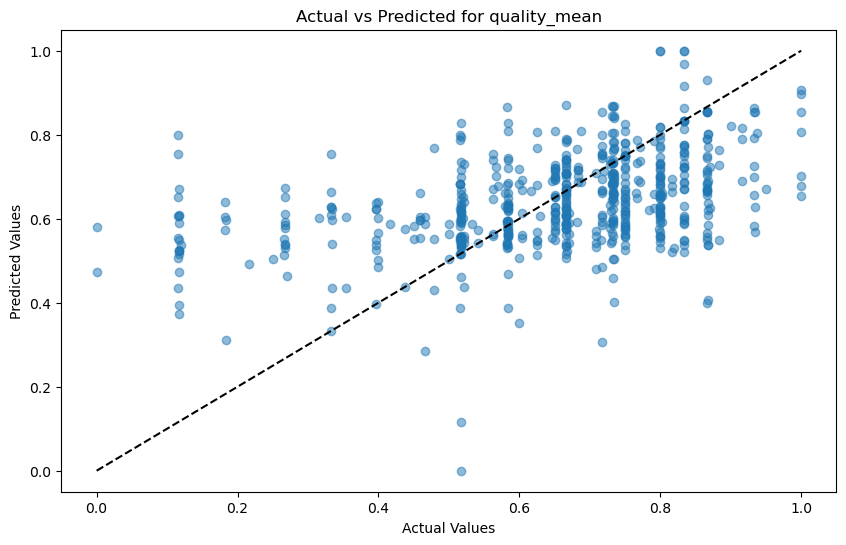

In [20]:
# Train the model
model, predictions = train_linear_model(X_train, y_train, X_test, vectorizer)

# Evaluate the model with MSE
mse = mean_squared_error(y_test, predictions)
print(f"MSE for {y_quality.name} with {train_linear_model.__name__}: {mse}")

# Calculate and print Pearson correlation
correlation, _ = pearsonr(y_test, predictions)
print(f"Pearson Correlation for {y_quality.name} with {train_linear_model.__name__}: {correlation}")

# Plot actual vs predicted values
plot_predictions(y_test, predictions, f"Actual vs Predicted for {y_quality.name}")

MSE for quality_mean with train_ridge_model: 0.02892664840109714
Pearson Correlation for quality_mean with train_ridge_model: 0.44804280349599407


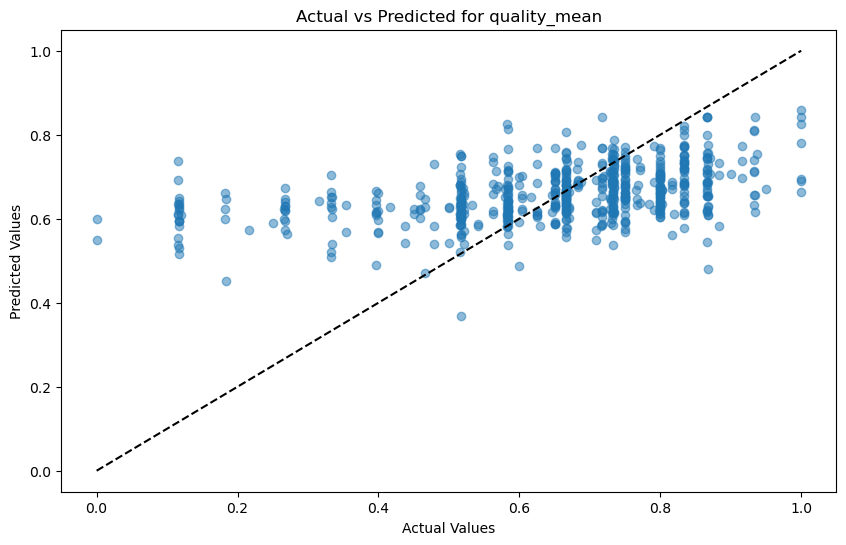

In [21]:
# Train the model
model, predictions = train_ridge_model(X_train, y_train, X_test, vectorizer)

# Evaluate the model with MSE
mse = mean_squared_error(y_test, predictions)
print(f"MSE for {y_quality.name} with {train_ridge_model.__name__}: {mse}")

# Calculate and print Pearson correlation
correlation, _ = pearsonr(y_test, predictions)
print(f"Pearson Correlation for {y_quality.name} with {train_ridge_model.__name__}: {correlation}")

# Plot actual vs predicted values
plot_predictions(y_test, predictions, f"Actual vs Predicted for {y_quality.name}")

In [22]:
# Assuming 'vectorizer' is a TfidfVectorizer instance and 'model' is a Ridge instance
importances = get_linear_feature_importances(vectorizer, model)

sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
print(f"Top 10 influential features for {y_quality.name}: {sorted_importances[:10]}")

Top 10 influential features for quality_mean: [('climate', 0.1951084876411143), ('earth', 0.16162595156603893), ('mangelernährung', 0.14971503202626366), ('ªª', 0.1493063063031146), ('калория', 0.14895845328943574), ('bir', 0.14734622932195643), ('الطاقة', 0.13987791184503418), ('mmr', 0.13103596203576764), ('twitter', 0.12937794860548052), ('site', 0.12916085627424886)]


MSE for quality_mean with train_random_forest_model: 0.029407850890578218
Pearson Correlation for quality_mean with train_random_forest_model: 0.42082570005952413


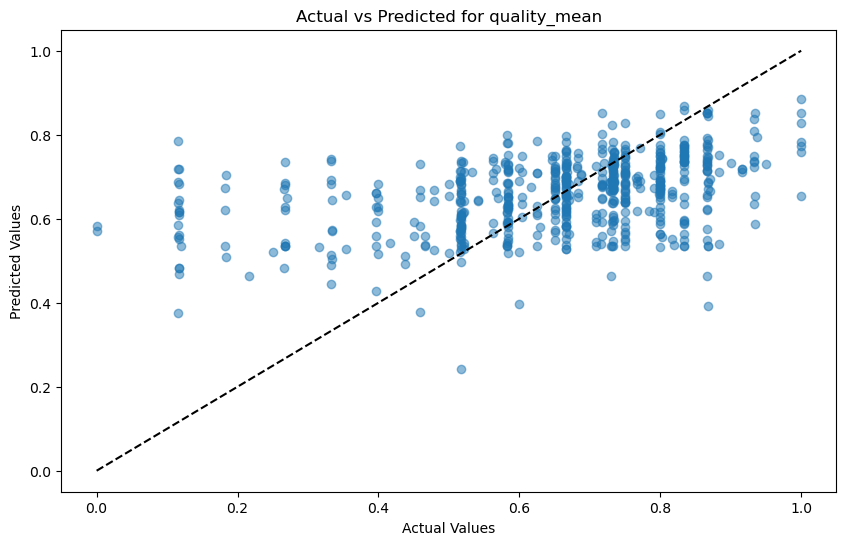

In [23]:
# Train the model
model, predictions = train_random_forest_model(X_train, y_train, X_test, vectorizer, n_estimators=50)

# Evaluate the model with MSE
mse = mean_squared_error(y_test, predictions)
print(f"MSE for {y_quality.name} with {train_random_forest_model.__name__}: {mse}")

# Calculate and print Pearson correlation   
correlation, _ = pearsonr(y_test, predictions)
print(f"Pearson Correlation for {y_quality.name} with {train_random_forest_model.__name__}: {correlation}")

# Plot actual vs predicted values
plot_predictions(y_test, predictions, f"Actual vs Predicted for {y_quality.name}")

In [24]:
def bootstrap_ridge_regression_with_coefs(X, y, X_test, y_test, n_iterations=1000, alpha=1.0):
    mse_scores = []
    r2_scores = []
    correlations = []
    coefficient_list = []  # List to store coefficients for each iteration

    for i in tqdm(range(n_iterations)):
        # Resample the training data with replacement
        X_train_resampled, y_train_resampled = resample(X, y)
        
        # Train the model on the resampled data
        model, predictions = train_ridge_model(X_train_resampled, y_train_resampled, X_test, vectorizer, alpha=alpha)
        
        # Evaluate the model
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        correlation, _ = pearsonr(y_test, predictions)
        
        # Store the scores and coefficients
        mse_scores.append(mse)
        r2_scores.append(r2)
        correlations.append(correlation)
        coefficient_list.append(model.coef_)  # Assuming 'ridge' is the name of the Ridge step in your pipeline

    # Process coefficient statistics
    coefficients = np.mean(np.array(coefficient_list), axis=0)  # Average coefficients across all iterations
    feature_names = vectorizer.get_feature_names_out()  # Get feature names from the TF-IDF vectorizer

    return mse_scores, r2_scores, correlations, coefficients, feature_names

In [25]:
mse_scores, r2_scores, correlations, coefficients, feature_names = bootstrap_ridge_regression_with_coefs(
    X_train, y_train, X_test, y_test, n_iterations=100, alpha=1.0)

# Sort features by the absolute value of their coefficients
sorted_features = sorted(zip(feature_names, coefficients), key=lambda x: x[1], reverse=True)

# Print top 10 influential features
print("Top 10 influential features:")
for feature, coef in sorted_features[:20]:
    print(f"{feature}: {coef}")
print("\nBottom 10 influential features:")
for feature, coef in sorted_features[-20:]:
    print(f"{feature}: {coef}")

100%|██████████| 100/100 [04:28<00:00,  2.69s/it]


Top 10 influential features:
climate: 0.1601660461655111
bir: 0.1380847568960984
earth: 0.1367928167908508
ªª: 0.13088223692784598
mangelernährung: 0.12987575462091575
калория: 0.1279735598210886
mrna: 0.11994723903260575
twitter: 0.11193976100578672
mmr: 0.1113744300006081
energi: 0.10633360995097643
الطاقة: 0.10514465980854566
pueden: 0.10106960237138823
facebook: 0.09794473017628617
site: 0.09793679712345713
space: 0.09193145694104744
tierra: 0.09112022389257872
vaccini: 0.09039867680656932
eposta: 0.08993910397373105
genome: 0.08983525998030989
autism: 0.08942655045562362

Bottom 10 influential features:
القيادة: -0.11908959493270023
السيارات: -0.12081879869242589
עדשות: -0.1211650836438373
enthusiasm: -0.12206387697048589
please: -0.12250424375487451
الطبع: -0.12304775375301023
microbiology: -0.12718956007074878
frete: -0.127234972111254
1400: -0.12740166121285784
도서: -0.13212602754775957
プレスリリース: -0.1385787880214612
dunia: -0.13911882652259996
flood: -0.14119949437317952
mirihi: 

# Ridge regression with deviding the data to languages

In [26]:
def bootstrap_ridge(X, y, n_iterations=1000, alpha=1.0):
    coefs = []
    for _ in tqdm(range(n_iterations)):
        X_resampled, y_resampled = resample(X, y)
        model = Ridge(alpha=alpha)
        model.fit(X_resampled, y_resampled)
        coefs.append(model.coef_)
    return np.array(coefs)

In [27]:
new_X = X.dropna(subset=['quality_mean', 'accessibility_mean'])

In [28]:
results = {}

for lang in cleaned_array:
    print(f"Processing language: {lang}")
    language_data = new_X[new_X['langs'] == lang]
    X_lang = language_data['cleaned_text']
    y_lang = language_data['quality_mean'] # Assuming you have a target column

    vectorizer_lang = TfidfVectorizer()
    X_train_lang_tfidf = vectorizer_lang.fit_transform(X_lang)

    # Apply bootstrap to get coefficients
    coefs = bootstrap_ridge(X_train_lang_tfidf, y_lang, n_iterations=10000, alpha=1.0)
    
    # Store results including mean and confidence intervals of coefficients
    mean_coefs = np.mean(coefs, axis=0)
    ci_lower = np.percentile(coefs, 2.5, axis=0)
    ci_upper = np.percentile(coefs, 97.5, axis=0)

    results[lang] = {
        'mean_coefs': mean_coefs,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'vectorizer': vectorizer_lang
    }

Processing language: Zulu


100%|██████████| 10000/10000 [00:19<00:00, 502.69it/s]


Processing language: Portuguese


100%|██████████| 10000/10000 [00:37<00:00, 266.42it/s]


Processing language: Hindi


100%|██████████| 10000/10000 [01:49<00:00, 91.46it/s]


Processing language: Spanish


100%|██████████| 10000/10000 [00:33<00:00, 297.46it/s]


Processing language: Taiwanese


100%|██████████| 10000/10000 [00:10<00:00, 989.26it/s]


Processing language: Japanese


100%|██████████| 10000/10000 [00:11<00:00, 833.52it/s]


Processing language: Indonesian


100%|██████████| 10000/10000 [00:15<00:00, 646.07it/s]


Processing language: Afrikaans


100%|██████████| 10000/10000 [00:18<00:00, 537.81it/s]


Processing language: English


100%|██████████| 10000/10000 [00:32<00:00, 309.48it/s]


Processing language: Hebrew


100%|██████████| 10000/10000 [00:32<00:00, 305.58it/s]


Processing language: Korean


100%|██████████| 10000/10000 [00:25<00:00, 395.95it/s]


Processing language: Vietnamese


100%|██████████| 10000/10000 [00:21<00:00, 474.32it/s]


Processing language: Swahili


100%|██████████| 10000/10000 [00:32<00:00, 305.52it/s]


Processing language: French


100%|██████████| 10000/10000 [00:37<00:00, 269.34it/s]


Processing language: Arabic


100%|██████████| 10000/10000 [00:32<00:00, 311.40it/s]


Processing language: Chinese


100%|██████████| 10000/10000 [00:11<00:00, 896.47it/s]


Processing language: Ukrainian


100%|██████████| 10000/10000 [00:26<00:00, 380.97it/s]


Processing language: Italian


100%|██████████| 10000/10000 [00:35<00:00, 284.20it/s]


Processing language: Russian


100%|██████████| 10000/10000 [00:34<00:00, 289.90it/s]


Processing language: Turkish


100%|██████████| 10000/10000 [00:34<00:00, 288.27it/s]


Processing language: German


100%|██████████| 10000/10000 [00:25<00:00, 395.57it/s]


In [29]:
for lang, data in results.items():
    feature_names = data['vectorizer'].get_feature_names_out()
    sorted_indices = np.argsort(-np.abs(data['mean_coefs']))  # Sort by importance
    top_features = sorted_indices[:10]  # Choose top 10 features to display
    print(f"Language: {lang}")
    print("Top Feature Importances:")
    for idx in top_features:
        feature = feature_names[idx]
        coef = data['mean_coefs'][idx]
        ci_low = data['ci_lower'][idx]
        ci_high = data['ci_upper'][idx]
        print(f"{feature}: {coef:.4f} (95% CI: [{ci_low:.4f}, {ci_high:.4f}])")

Language: Zulu
Top Feature Importances:
zuhilovedcom: -0.1080 (95% CI: [-0.2282, 0.0000])
kakhulu: 0.1061 (95% CI: [0.0683, 0.1410])
weight: -0.0961 (95% CI: [-0.1707, 0.0000])
futhi: 0.0924 (95% CI: [0.0482, 0.1358])
izinkanyezi: 0.0886 (95% CI: [0.0088, 0.1413])
inkanyezi: 0.0791 (95% CI: [0.0315, 0.1168])
flood: -0.0781 (95% CI: [-0.1608, 0.0000])
drought: -0.0726 (95% CI: [-0.1583, 0.0000])
enthusiasm: -0.0717 (95% CI: [-0.1569, 0.0000])
2024: -0.0678 (95% CI: [-0.1417, 0.0075])
Language: Portuguese
Top Feature Importances:
frete: -0.1533 (95% CI: [-0.3011, 0.0046])
esqueci: -0.1345 (95% CI: [-0.2788, 0.0000])
senha: -0.1345 (95% CI: [-0.2788, 0.0000])
grátis: -0.1171 (95% CI: [-0.2523, 0.0119])
história: -0.0543 (95% CI: [-0.0784, -0.0259])
calorias: 0.0541 (95% CI: [-0.0008, 0.0946])
educacional: -0.0538 (95% CI: [-0.1132, 0.0010])
peso: 0.0535 (95% CI: [-0.0036, 0.1141])
vacinas: 0.0504 (95% CI: [0.0149, 0.0774])
defendemos: -0.0502 (95% CI: [-0.1000, 0.0000])
Language: Hindi
To

# Using k-fold cross-validation

In [35]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_data)  # Pre-fit the vectorizer to be used in train_ridge_model
alpha_value = 1.0

# K-fold setup
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Collect coefficients from each fold
all_coefficients = []
for train_index, test_index in kf.split(X_data):
    X_train_fold = X_data.iloc[train_index]
    X_test_fold = X_data.iloc[test_index]
    y_train_fold = y_quality.iloc[train_index]
    y_test_fold = y_quality.iloc[test_index]

    # Train the model using the predefined function
    model, predictions = train_ridge_model(X_train_fold, y_train_fold, X_test_fold, vectorizer, alpha_value)

    # Store coefficients from this fold
    all_coefficients.append(model.coef_)

# Average the coefficients
average_coefficients = np.mean(all_coefficients, axis=0)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Sorting coefficients and selecting top and bottom 10
sorted_indices = np.argsort(average_coefficients)
top_indices = sorted_indices[-20:]  # Largest
bottom_indices = sorted_indices[:20]  # Smallest

# Print top 10 largest coefficients
print("Top 10 largest coefficients:")
for index in top_indices:
    print(feature_names[index], average_coefficients[index])

# Print top 10 smallest coefficients
print("\nTop 10 smallest coefficients:")
for index in bottom_indices:
    print(feature_names[index], average_coefficients[index])

Top 10 largest coefficients:
images 0.09988323263159898
chakula 0.10250669783601155
kara 0.10585123592202499
genome 0.1058951738488872
zaidi 0.10590279615027806
space 0.10696022741978137
الطاقة 0.10854840942000636
pueden 0.11094958323318242
eposta 0.11145285764776351
facebook 0.11552039651024806
словарь 0.12053153389677336
mmr 0.12254913307693353
earth 0.12291320569197442
mangelernährung 0.12724157000944653
site 0.12834073811013452
калория 0.12888703012990857
twitter 0.13166320328793374
ªª 0.1392343582999946
bir 0.16780893615467196
climate 0.19877939077868848
Top 10 smallest coefficients:
المعجم -0.35538435117596084
заинтересовать -0.19584279339985602
zuhilovedcom -0.18957672361172265
1400 -0.17985985498618576
401800 -0.15805242463017616
原子 -0.1579395717628529
プレスリリース -0.14927046770546007
frete -0.14824954005959814
microbiology -0.14639621281609477
roma -0.14545801353334298
flood -0.1450249291604903
mirihi -0.14377755613921278
policy -0.14357755668133249
энергия -0.14106721938903471
ra